# Hyperparameter optimization with Population-based Training 

In this demo we will use Population-based training (PBT) to optimize the learning rate and weight decay for fine-tuning our classifier based on SageMakerTune.

**Note**: This notebook demonstrates the **remote tuning** feature of SageMaker Tune, meaning that the HPO experiment with all its training jobs is executed remotely as a SageMaker training job. Advantages of remote tuning include:

* You can run this notebook on your local machine (as long as it can launch SageMaker training jobs), or on a notebook
  instance without GPUs
* You can start many experiments in parallel, they'll be executed as different SageMaker training jobs
* Your training code can use a SageMaker framework, you don't have to build Docker containers (in the example here, we
  will use the **HuggingFace** framework)
* Experiment logs and results are archived as for any SageMaker training jobs, result files are written to S3

On the other hand, remote tuning can be a bit clunky for debugging. Results are not immediately available as local files, for example. With SageMaker Tune, you can pick and choose.

In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Install SageMakerTune

First we need to install SagemakerTune. The command below assumes you are on a SageMaker notebook instance, where the SageMaker Tune sources are checked out.

In [2]:
%cd /home/ec2-user/develop/sagemaker-tune/
! pip install --upgrade pip
! pip install -e .[gpsearchers]
%cd examples/hugging_face_example/

/home/ec2-user/develop/sagemaker-tune
Obtaining file:///home/ec2-user/develop/sagemaker-tune
  Preparing metadata (setup.py) ... done
  Attempting uninstall: sagemaker-tune
    Found existing installation: sagemaker-tune 0.1
    Uninstalling sagemaker-tune-0.1:
      Successfully uninstalled sagemaker-tune-0.1
  Running setup.py develop for sagemaker-tune
/home/ec2-user/develop/sagemaker-tune/examples/hugging_face_example


### Defining Optimization Parameters

In [3]:
# Specifies the maximum number of parallel workers to evaluate hyperparameter configurations. Training jobs of different
# workers are executed as subprocesses (we are using the "local" back-end). This means you should choose the number of
# workers to be no larger than the number of GPUs on the instance.
# If you like to use more workers or run on smaller GPU instances, you should use the "sagemaker" back-end, which
# however comes with larger overheads for starting and stopping a training job.
n_workers = 4

# The size of the population that PBT maintains
population_size = 8

# Specifies whether we maximize or minimize our metric
mode = 'max'

# The metric we aim to optimize. Needs to match the key name reported in your training script
metric = 'accuracy'

# PBT assignes more resources to better performing models. This parameters defines the resources that we want to use
resource_attr = 'iteration'

# The maximum amount of resources we can assign to any model.
max_iterations = 73 # corresponds to 3 epochs

## Defining Configuration Space

Here we define the domain for each hyperparameter we want to optimize

In [4]:
from sagemaker_tune.search_space import loguniform

config_space = {
    'learning_rate': loguniform(1e-6, 1e-4),
    'weight_decay': loguniform(1e-6, 1e-4)
}

If we have additional arguments that we want pass to our train function, we can add them to the config space

In [5]:
config_space['model_name'] = 'distilbert-base-uncased'

### Define Hugging Face SageMaker Estimator

In order to use SagemakerTune we need to modify our train function slightly. First we will add an additional
command line argument to specify the hyperparameters. Additionally we will add an argument that specifies where we will store the checkpoints. This will parameter will be automatically set by SagemakerTune and allows is to start the evaluation of a configuration from a previous configuration


```
from sagemaker_tune.constants import SMT_CHECKPOINT_DIR


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=float, default=5e-5)
    parser.add_argument("--weight_decay", type=float, default=5e-5)
    parser.add_argument("--eval_steps", type=int, default=32)
    parser.add_argument("--output_data_dir", type=str, default='./output')

    parser.add_argument(f"--{SMT_CHECKPOINT_DIR}", type=str)

```

Next we need to report the performance of the current model back to SageMakerTune. For that we will
add a callback function, which reports results back to SageMaker Tune after each evaluation:

```
    from sagemaker_tune.report import Reporter

    report = Reporter()

    class Callback(TrainerCallback):
        def __init__(self):
            self.iteration = 1

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            # Feed the validation accuracy back to Tune
            report(iteration=self.iteration, accuracy=metrics['eval_accuracy'])
            self.iteration += 1


    trainer.add_callback(Callback())
```    

Lastly, we need to make sure that if SageMakerTune provides us with a checkpoint, we start the evaluation from there:

``` 
    if os.listdir(checkpoint_dir) == []:
        trainer.train()
    else:
        trainer.train(resume_from_checkpoint=os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[0]))
``` 

In [6]:
from pathlib import Path

import sagemaker_tune

p = Path.cwd()
training_script = str(p) +  '/scripts/train.py'

### Defining Backend

We will use the LocalBackend which distributed the HPO on the local machine. Alternatively, we can also use the SageMakerBackend where each trial, i.e function evaluation will be executed on a Sagemaker instance.

In [7]:
from sagemaker_tune.backend.local_backend import LocalBackend
    
backend = LocalBackend(entry_point=training_script)

### Defining PBT

In [8]:
from sagemaker_tune.optimizer.schedulers.pbt import PopulationBasedTraining

scheduler =  PopulationBasedTraining(config_space=config_space,
                                  metric=metric,
                                  resource_attr=resource_attr,
                                  population_size=population_size,
                                  mode=mode,
                                  max_t=max_iterations,
                                  perturbation_interval=1)

INFO:sagemaker_tune.optimizer.schedulers.searchers.utils.default_arguments:scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False

INFO:sagemaker_tune.optimizer.schedulers.fifo:Master random_seed = 3117375465


## Remote Tuning

We are now ready to start tuning. As noted above, we will use **remote tuning**: the experiment will be run on a suitable instance, instead of locally on the machine this notebook is running. Results will be written to S3.

In [9]:
from sagemaker_tune.tuner import Tuner
from sagemaker_tune.stopping_criterion import StoppingCriterion
from sagemaker_tune.remote.remote_launcher import RemoteLauncher

# Tuning will run for 3 hours (which won't give us competitive results, but it's just a demo)
scheduler_timeout = 3 * 3600
stop_criterion = StoppingCriterion(max_wallclock_time=scheduler_timeout)

# Tuner, as run on the remote instance
experiment_name = 'pbt-example'
local_tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    tuner_name=experiment_name)

print(f"Experiment launched as {local_tuner.name}")

# The experiment is run as SageMaker estimator, we need to set its parameters
estimator_kwargs = {
    'framework_version': '4.4',
    'pytorch_version': '1.6',
    'max_run': int(1.01 * scheduler_timeout),
}

dependencies = [str(Path.cwd().parent.parent / "benchmarks/")]
tuner = RemoteLauncher(
    tuner=local_tuner,
    dependencies=dependencies,
    instance_type='ml.g4dn.12xlarge',
    framework='HuggingFace',
    estimator_kwargs=estimator_kwargs,
    no_tuner_logging=True)

tuner.run(wait=False)

INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/pbt-example-2021-10-22-13-41-19-605
INFO:sagemaker_tune.backend.sagemaker_backend.sagemaker_utils:No Sagemaker role passed as environment variable $AWS_ROLE, inferring it.
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Experiment launched as pbt-example-2021-10-22-13-41-19-605


INFO:root:copy endpoint files from /home/ec2-user/develop/sagemaker-tune/examples/hugging_face_example/scripts to /home/ec2-user/develop/sagemaker-tune/tuner
INFO:root:copy endpoint script requirements to /home/ec2-user/develop/sagemaker-tune/sagemaker_tune/remote
INFO:root:Tuner will checkpoint results to s3://sagemaker-us-west-2-719355911555/sagemaker-tune/pbt-example-2021-10-22-13-41-19-605/
INFO:root:Fetching sagemaker tune image 719355911555.dkr.ecr.us-west-2.amazonaws.com/smt-cpu-py36
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pbt-example-2021-10-22-13-41-19-605


## Plotting Results

Results are written to S3 in regular intervals. For meaningful results, we need to wait until the SageMaker training job has finished.

The following plot shows the optimization process of PBT. Each dot represents the performance of 
the current model and the color indicates the same hyperparameter configuration. The solid blue line represents the 
performance of the best model found so far.

In [10]:
# Download results from S3 (please wait until experiment finished)
from sagemaker_tune.experiments import download_single_experiment
from sagemaker_tune.util import experiment_path

# If you plotting in the same notebook
tuner_name = local_tuner.name
# If you run plotting for results obtained earlier on (replace with values for your experiment)
# tuner_name = 'pbt-example-2021-10-22-13-41-19-605'
download_single_experiment(tuner_name)
tgt_dir = experiment_path(tuner_name=tuner_name)

INFO:root:downloading metadata.json on s3://sagemaker-us-west-2-719355911555/sagemaker-tune/pbt-example-2021-10-22-13-41-19-605
INFO:root:downloading results.csv.zip on s3://sagemaker-us-west-2-719355911555/sagemaker-tune/pbt-example-2021-10-22-13-41-19-605
INFO:root:downloading tuner.dill on s3://sagemaker-us-west-2-719355911555/sagemaker-tune/pbt-example-2021-10-22-13-41-19-605


(0.8, 0.95)

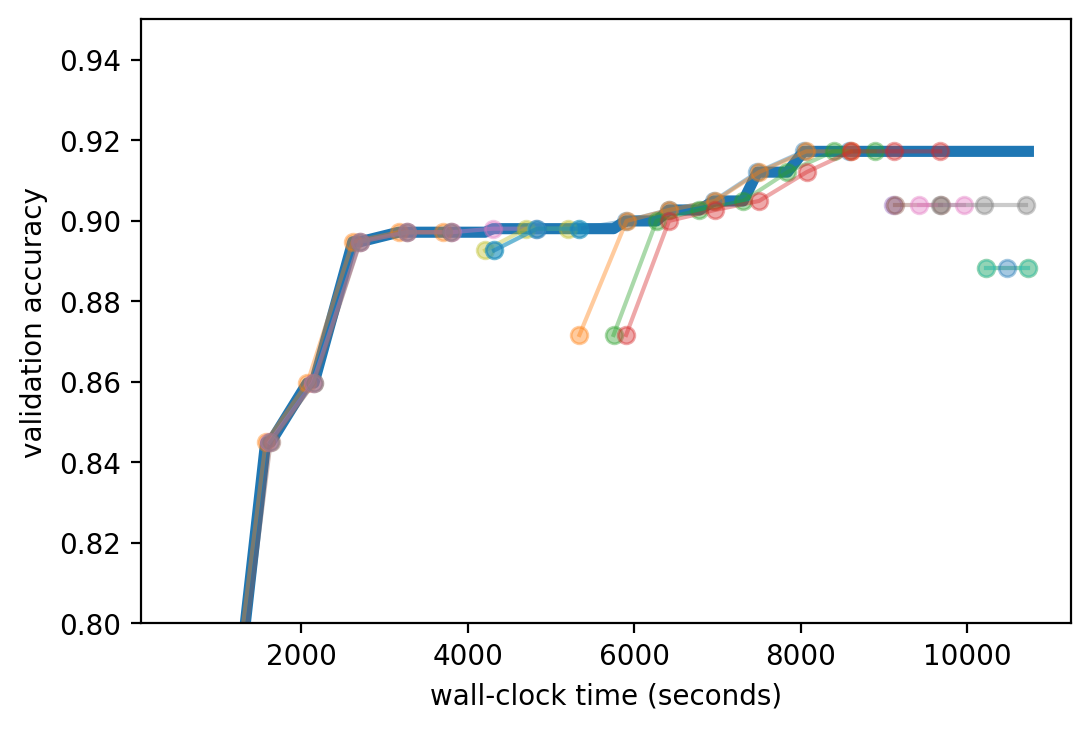

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from sagemaker_tune.experiments import load_experiment

plt.figure(dpi=200)
r = load_experiment(tgt_dir)
df = r.results
plt.plot(df['smt_tuner_time'], df['accuracy'].cummax(), linewidth=4)

for trial_id in df.trial_id.unique():
    sub_df = df[df['trial_id'] == trial_id]
    y = sub_df['accuracy'].cummax()
    rt =sub_df['smt_tuner_time']    
    plt.plot(rt, y, marker='o', alpha=0.4)

plt.ylabel('validation accuracy')
plt.xlabel('wall-clock time (seconds)')
plt.ylim(0.8, 0.95)